In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be installed via pip or conda.
# for more details, see: https://github.com/matplotlib/ipympl
%matplotlib widget

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

import time
import datetime

In [3]:
# import wrapper class PyVisa_Keysight_34465A from python file PyVisa_Keysight_34465A_class.py
# from ../PyVisa_Keysight_34465A_class.py import PyVisa_Keysight_34465A

# classe PyVisa_Keysight_34465A has to imported via importlib due to different path of notebook and class file
import importlib.util

spec = importlib.util.spec_from_file_location("PyVisa_Keysight_34465A", "./PyVisa_Keysight_34465A_class.py")
keysight_class = importlib.util.module_from_spec(spec)
spec.loader.exec_module(keysight_class)

In [4]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # add a row
    df.loc[-1] = row
    
    # shift the index
    df.index = df.index + 1
    
    # reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

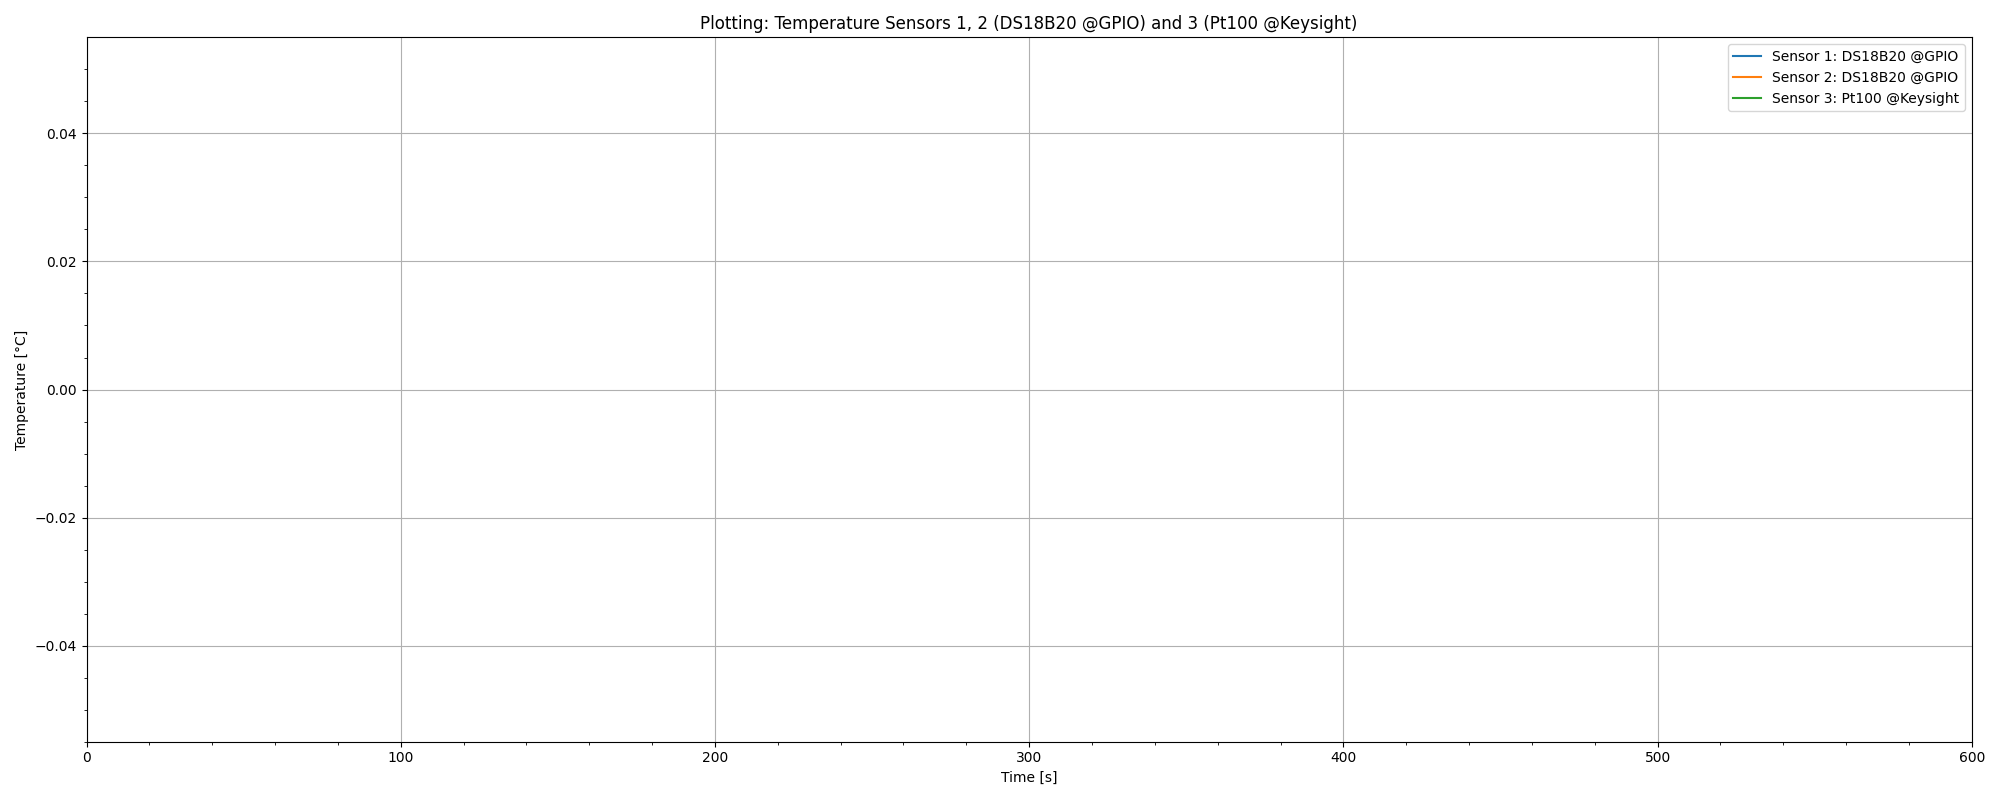

In [5]:
from w1thermsensor import W1ThermSensor, Sensor

INTERVAL = 0.5

# connect to DS18B20 sensors
sensor_obj = W1ThermSensor()
sensor_list = sensor_obj.get_available_sensors([Sensor.DS18B20])

# connect to Keysight 34465A
# IP of devices
ip_str = '192.168.12.150'
#ip_str = '192.168.10.113'

# create new device object for the digital multimeter (DMM) Keysight 34465A
dmm = keysight_class.PyVisa_Keysight_34465A(tcp_ip = ip_str)

# configure Keysight DMM for temperature measurement with a valid configuration
dmm.confTempMeasure('01_PT100_4WIRE')

# get starting time
time_start_sec = float("{:.2f}".format(time.time()))

# initialize temperature array in the size of the number of sensors
temp_array = np.empty(len(sensor_list), dtype=object)

# initialize the dataframe that will store the measured values
df_meas_values = pd.DataFrame(columns=['Time [s]', 'Sensor 1: DS18B20 @GPIO [°C]', 'Sensor 2: DS18B20 @GPIO [°C]', 'Sensor 3: Pt100 @Keysight [°C]'])

plt.ioff()

fig, ax = plt.subplots(figsize=(20,8))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'

plt.title('Plotting: Temperature Sensors 1, 2 (DS18B20 @GPIO) and 3 (Pt100 @Keysight)')

# define the limits of the x-axis in seconds, from when the canvas should be scrolled
xlim_left = 0
xlim_span = 600
xlim_right = xlim_left + xlim_span
xlim_scroll = xlim_span - 10

ax.set_xlim(xlim_left, xlim_right)

line_temp_1, = ax.plot(df_meas_values['Time [s]'], df_meas_values['Sensor 1: DS18B20 @GPIO [°C]'], label='Sensor 1: DS18B20 @GPIO')
line_temp_2, = ax.plot(df_meas_values['Time [s]'], df_meas_values['Sensor 2: DS18B20 @GPIO [°C]'], label='Sensor 2: DS18B20 @GPIO')
line_temp_3, = ax.plot(df_meas_values['Time [s]'], df_meas_values['Sensor 3: Pt100 @Keysight [°C]'], label='Sensor 3: Pt100 @Keysight')

ax.grid(True)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.minorticks_on()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.legend()
plt.tight_layout()

fig.canvas.draw()
fig.canvas.flush_events()

display(fig.canvas)

In [6]:
#display(fig.canvas)

while True:
    try:
        # Get time relative to starting time and round to 2 decimals
        timestamp_sec = float("{:.2f}".format(time.time() - time_start_sec))
        # convert timestamp in seconds to human readable time string
        timestamp_str = str(datetime.timedelta(seconds=timestamp_sec))

        i = 0
        for sensor in sensor_list:
            temp_array[i] = sensor.get_temperature()

            print("<{}>\t DS18B20 Sensor: {:d} of {:d}, Temperature: {:.3f} °C, ID: {}".format(timestamp_str, i+1, len(sensor_list), temp_array[i], sensor.id))
            i = i + 1

        # retrieve temperature value from Keysight DMM
        temp_dmm = dmm.getMeasurement()
        print("<{}>\t Pt100 Temperature: {:.7f} °C".format(timestamp_str, temp_dmm))
        
        values_row = [ timestamp_sec,
                       temp_array[0],
                       temp_array[1],
                       temp_dmm
                     ]

        dataframe_add_row(df_meas_values, values_row)

        # when the right edge of the canvas is reached, the canvas should continue to scroll to the left
        xlim_right = datetime.timedelta(seconds=df_meas_values['Time [s]'][0]) + datetime.timedelta(seconds=xlim_scroll)
        if (timestamp_sec >= xlim_right.total_seconds()):
            # drop first row of dataframe
            df_meas_values.drop(index=df_meas_values.head(1).index, inplace=True)
            # reset index of dataframe
            df_meas_values.reset_index(inplace=True, drop=True)

            # take the new first time value for the left boundary of the x-axis
            xlim_left = df_meas_values['Time [s]'][0]
            xlim_right = xlim_left + xlim_span
            ax.set_xlim(xlim_left, xlim_right)


        line_temp_1.set_xdata(df_meas_values['Time [s]'])
        line_temp_1.set_ydata(df_meas_values['Sensor 1: DS18B20 @GPIO [°C]'])

        line_temp_2.set_xdata(df_meas_values['Time [s]'])
        line_temp_2.set_ydata(df_meas_values['Sensor 2: DS18B20 @GPIO [°C]'])
        
        line_temp_3.set_xdata(df_meas_values['Time [s]'])
        line_temp_3.set_ydata(df_meas_values['Sensor 3: Pt100 @Keysight [°C]'])

        ax.relim()
        ax.autoscale_view()

        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(INTERVAL)
        
    except:
        print("Keyboard Interrupt ^C detected.")
        print("Bye.")
        break

<0:00:06.120000>	 DS18B20 Sensor: 1 of 2, Temperature: 20.438 °C, ID: 012116c9fc70
<0:00:06.120000>	 DS18B20 Sensor: 2 of 2, Temperature: 20.625 °C, ID: 01202ceb55a3
<0:00:06.120000>	 Pt100 Temperature: 20.7034536 °C
<0:00:09.370000>	 DS18B20 Sensor: 1 of 2, Temperature: 20.438 °C, ID: 012116c9fc70
<0:00:09.370000>	 DS18B20 Sensor: 2 of 2, Temperature: 20.625 °C, ID: 01202ceb55a3
<0:00:09.370000>	 Pt100 Temperature: 20.6874546 °C
<0:00:12.490000>	 DS18B20 Sensor: 1 of 2, Temperature: 20.438 °C, ID: 012116c9fc70
<0:00:12.490000>	 DS18B20 Sensor: 2 of 2, Temperature: 20.562 °C, ID: 01202ceb55a3
<0:00:12.490000>	 Pt100 Temperature: 20.6770632 °C
<0:00:15.740000>	 DS18B20 Sensor: 1 of 2, Temperature: 20.438 °C, ID: 012116c9fc70
<0:00:15.740000>	 DS18B20 Sensor: 2 of 2, Temperature: 20.562 °C, ID: 01202ceb55a3
<0:00:15.740000>	 Pt100 Temperature: 20.6660325 °C
<0:00:18.970000>	 DS18B20 Sensor: 1 of 2, Temperature: 20.438 °C, ID: 012116c9fc70
<0:00:18.970000>	 DS18B20 Sensor: 2 of 2, Tempera

In [7]:
df_meas_values

,Time [s],Sensor 1: DS18B20 @GPIO [°C],Sensor 2: DS18B20 @GPIO [°C],Sensor 3: Pt100 @Keysight [°C]
0,6.12,20.4375,20.6250,20.703454
1,9.37,20.4375,20.6250,20.687455
2,12.49,20.4375,20.5625,20.677063
3,15.74,20.4375,20.5625,20.666033
4,18.97,20.4375,20.5625,20.657357
...,...,...,...,...
65,216.58,29.0000,28.5625,27.677448
66,219.78,28.8750,28.5000,27.536579
67,222.96,28.8125,28.3750,27.418549
68,226.10,28.6875,28.3750,27.285270
